In [3]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, root, least_squares
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import CubicSpline

In [4]:
default_configs = {
    'planet_num': 2,
    'planet_mass': [1e-7, 1e-7],
    'kappa': 2,
    'inner_period': 2*np.pi,
    'C': [],
    'target_mean_anomaly': 4*np.pi,
    'init_time_step': 0.2,
    'bisection_tol': 1e-9,
}

In [5]:
def integrate_one_cycle(sim, configs):
    time_step = configs['init_time_step']
    bisection_tol = configs['bisection_tol']
    target_mean_anomaly = configs['target_mean_anomaly']
    current_mean_anomaly = 0
    N_peri = 0
    counter = 0
    M = [0]
    times = [sim.t]
    
    while True:
        # Integrate by stepping one time
        time_now = sim.t + time_step
        sim.integrate(time_now)
        
        # Getting the actual current mean anomaly
        current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi

        # Correct mean anomaly
        if current_mean_anomaly - M[-1] < 0:
            N_peri += 1
            current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi 
            M.append(current_mean_anomaly)
            # print(f"Starting {N_peri}")
        else:
            M.append(current_mean_anomaly)

        # Store time
        times.append(sim.t)

        # Find the precise 16pi
        if current_mean_anomaly > target_mean_anomaly:
            target_time = bisection_M(sim, target_mean_anomaly, times[-2], times[-1], M[-2], M[-1], tol=bisection_tol)
            sim.integrate(target_time)
            return sim, target_time, times, M
            # return M, times, target_time


def bisection_M(sim, target, a, b, Ma, Mb, tol=1e-9, doom_counts=10000):
    """
    Bisection method on M. The function terminates after a certain attempt.
    """    
    func = CubicSpline([a, b], [Ma, Mb], bc_type='natural')

    while True:
        half = (a + b)/2
        
        # If the target lies on the first half
        if (func(half) - target) > 0:
            a = a
            b = half
    
        # If the target lies on the second half
        if (func(half) - target) < 0:
            a = half
            b = b
    
        # print(np.abs(fa - fb))
        
        if np.abs(a - b) < tol:
            # print(half, func(half))
            break

    return half

def wrap_angles(angles):
    for i, ang in enumerate(angles):
        while ang > np.pi or ang <= -np.pi:
            if ang < 0:
                ang += 2*np.pi
            elif ang > 0:
                ang -= 2*np.pi

        angles[i] = ang

    return angles

def wrap_angle(ang):
    while ang > np.pi or ang <= -np.pi:
        if ang < 0:
            ang += 2*np.pi
        elif ang > 0:
            ang -= 2*np.pi
    
    return ang

In [6]:
def init_simulation(theta, configs):
    inner_period = configs['inner_period']
    
    init_e = 10 ** np.array(theta[0:2], dtype=np.float64)
    init_M = theta[2]
    init_pomega = -theta[3]
    
    sim = rebound.Simulation()

    sim.add(m=1)
    sim.add(m=configs['planet_mass'][0], P=inner_period, e=init_e[0])
    sim.add(m=configs['planet_mass'][1], P=inner_period*configs['kappa'], pomega=init_pomega, M=init_M, e=init_e[1])
    
    return sim


def optimizing_function(theta, configs):
    init_theta = theta
    init_sim = init_simulation(init_theta, configs)

    final_sim, target_time, _, _ = integrate_one_cycle(init_sim, configs)
    final_sim.move_to_hel()
    

    final_theta = np.log10(final_sim.particles[1].e), np.log10(final_sim.particles[2].e), wrap_angle(final_sim.particles[2].M), wrap_angle(final_sim.particles[1].pomega - final_sim.particles[2].pomega)

    theta_diff = np.asarray(final_theta) - np.asarray(init_theta)
    # print(init_theta, final_theta)
    # print(theta_diff)

    diff = np.sum(theta_diff ** 2)
    # print(diff)
    return diff

    # return theta_diff

In [7]:
# Continuation

mass_cands = 10 ** np.arange(-12., -3., 1.)
# mass_cands = [1e-7]

init_theta = [-1, -1, 0, 0]
bounds = [(-3, -0.5), (-3, -0.5), (-np.pi, np.pi), (-np.pi, np.pi)]

for i, m in enumerate(mass_cands):
    m_configs = default_configs.copy()
    m_configs['planet_mass'] = [m, m]
    m_configs['kappa'] = 2

    res_0 = minimize(optimizing_function, x0=init_theta, method='Nelder-Mead', bounds=bounds, args=(m_configs,), options={ 'xatol':1e-14, 'fatol':1e-14})
    print(f'Masses {i}, first done!')
    res = minimize(optimizing_function, x0=res_0.x, method='L-BFGS-B', args=(m_configs,), bounds=bounds, tol=1e-14)
    print(f'Masses {i}, second done!')
    init_theta = res.x
    print(res.x, res.fun)

print(res.x)
print(m_configs)
    
    

Masses 0, first done!
Masses 0, second done!
[-1.00078125e+00 -1.00000000e+00 -1.76530832e-18 -9.71067141e-18] 4.940122213663123e-32
Masses 1, first done!
Masses 1, second done!
[-1.03543744e+00 -1.01585054e+00 -1.76584378e-18 -9.60670199e-18] 9.540692745768288e-35
Masses 2, first done!
Masses 2, second done!
[-1.01036044e+00 -1.05275448e+00 -1.84654836e-18 -9.95569546e-18] 4.940633218934869e-32
Masses 3, first done!
Masses 3, second done!
[-5.59840778e-01 -1.19002406e+00 -2.12295867e-18 -1.18993688e-17] 1.247205357433157e-32
Masses 4, first done!
Masses 4, second done!
[-5.61713863e-01 -1.21458245e+00 -2.12804646e-18 -1.20614875e-17] 1.4956028930542505e-15
Masses 5, first done!
Masses 5, second done!
[-7.88473200e-01 -1.72883791e+00 -2.24463382e-18 -3.32968748e-18] 2.3863200569198457e-20
Masses 6, first done!
Masses 6, second done!
[-8.11470058e-01 -1.80335558e+00 -2.12945727e-18 -2.51415342e-18] 2.0174120017572103e-23
Masses 7, first done!
Masses 7, second done!
[-8.10200419e-01 -1.7

In [8]:
res

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 7.261244629454573e-17
        x: [-8.097e-01 -1.802e+00 -2.347e-18 -2.775e-18]
      nit: 0
      jac: [ 1.730e-07  1.398e-06  1.246e-06  7.744e-07]
     nfev: 105
     njev: 21
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

12.560133007913812
-0.00383454493522863


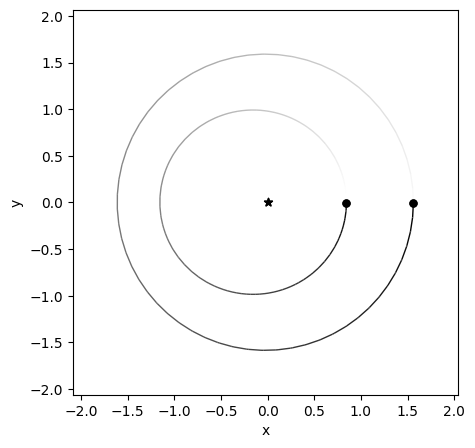

In [11]:

sim = init_simulation(res.x, m_configs)
_, target_time, times, M = integrate_one_cycle(sim, m_configs)
print(target_time)
sim.integrate(target_time)
print(sim.particles[1].pomega)
rebound.OrbitPlot(sim)


In [12]:
marks = np.arange(0, 5001, 1)

print(target_time)
print(m_configs)

sim = init_simulation(res.x, m_configs)
_, target_time, _, _ = integrate_one_cycle(sim, m_configs)

angle_hist = np.zeros(len(marks))
pomega_1_hist = np.zeros(len(marks))
pomega_2_hist = np.zeros(len(marks))


for i, m in enumerate(marks):
    sim.integrate(sim.t + target_time)
    sim.t = 0
    sim.move_to_hel()
    
    angle_hist[i] = sim.particles[1].l - 2*sim.particles[2].l + sim.particles[1].pomega

    pomega_1_hist[i] = sim.particles[1].pomega
    pomega_2_hist[i] = sim.particles[2].pomega

    # print(sim.particles[1].l, sim.particles[2].l, sim.particles[1].pomega)

12.560133007913812
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': 2, 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.2, 'bisection_tol': 1e-09}


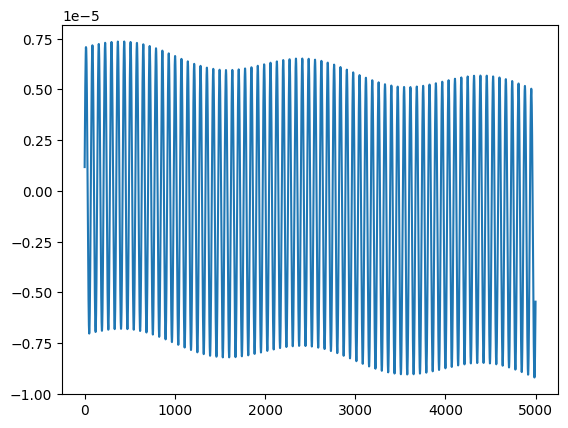

In [13]:
plt.plot(wrap_angles(angle_hist))

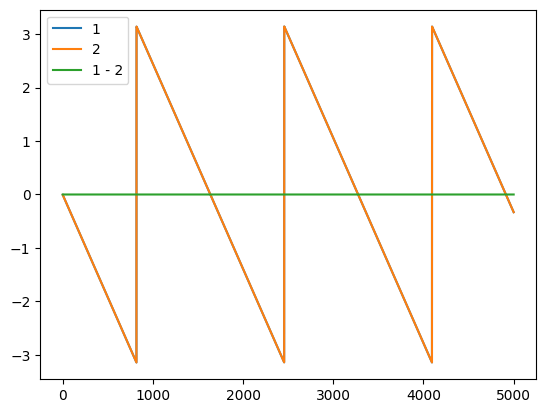

In [14]:
plt.plot(wrap_angles(pomega_1_hist), label='1')
plt.plot(wrap_angles(pomega_2_hist), label='2')
plt.plot(wrap_angles(pomega_1_hist - pomega_2_hist), label='1 - 2')
plt.legend()